In [114]:
import pandas as pd
import numpy as np
from datetime import datetime
from itertools import combinations
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
from pykalman import KalmanFilter
from math import sqrt
import matplotlib.pyplot as plt
import riskfolio as rp
import os
from pathlib import Path
import glob 



In [83]:
# ─── PARAMETERS ─────────────────────────────────────────────────────────────
START_DATE = "2018-01-01"
END_DATE   = "2025-01-01"
OUT_CSV    = "vn_top500_closes_2018_2025.csv"
EXCHANGE   = "HOSE,HNX,UPCOM"
SOURCES     = ['VCI', 'SSI']

TRAIN_FRAC = 0.7       # 70% train / 30% test
MIN_COMMON = 100       # min days overlap
P_THRESH   = 0.05      # cointegration p-value threshold
ENTRY_Z    = 1.25      # entry z-score
EXIT_Z     = 0.5       # exit z-score
MIN_HL     = 5
MAX_HL     = 252
COMMISSION = 0.002    # 0.2% round-trip split per side
SLIPPAGE   = 0.0015 
MIN_COVERAGE_PCT = 0.90   # require ≥90% of the “best” non-NaN days

In [50]:
from vnstock3 import Screener

# Use Screener to get all stocks from HOSE, HNX, UPCoM
screener = Screener()
all_stocks = screener.stock(params={"exchangeName": "HOSE,HNX,UPCOM"}, limit=2000)
# Convert marketCap to numeric and sort descending
all_stocks['market_cap'] = pd.to_numeric(all_stocks['market_cap'], errors='coerce')
all_stocks = all_stocks.dropna(subset=['market_cap']).sort_values('market_cap', ascending=False)
# Select top 500 by market cap
universe = all_stocks['ticker'].head(500).tolist()
print(f"Universe: {len(universe)} VN stocks by market cap")
universe

Universe: 500 VN stocks by market cap


['VCB',
 'VIC',
 'VHM',
 'BID',
 'TCB',
 'VGI',
 'ACV',
 'CTG',
 'FPT',
 'HPG',
 'MBB',
 'VPB',
 'GAS',
 'MCH',
 'VNM',
 'ACB',
 'GVR',
 'LPB',
 'MWG',
 'MSN',
 'MVN',
 'HDB',
 'HVN',
 'STB',
 'SAB',
 'BCM',
 'VRE',
 'SHB',
 'VIB',
 'BSR',
 'SSB',
 'VEA',
 'VJC',
 'SSI',
 'FOX',
 'PLX',
 'VEF',
 'EIB',
 'BVH',
 'GEE',
 'TPB',
 'KSV',
 'REE',
 'DGC',
 'SSH',
 'MSB',
 'POW',
 'KDH',
 'PNJ',
 'GEX',
 'OCB',
 'VCI',
 'NAB',
 'GMD',
 'FRT',
 'NVL',
 'VND',
 'PGV',
 'KBC',
 'VGC',
 'MSR',
 'VIX',
 'KSF',
 'HCM',
 'DNH',
 'DCM',
 'QNS',
 'VSF',
 'VPI',
 'KDC',
 'MBS',
 'PDR',
 'DXG',
 'SBT',
 'DHG',
 'SIP',
 'VTP',
 'HAG',
 'IDC',
 'IDP',
 'DPM',
 'NLG',
 'VCG',
 'PVS',
 'NVB',
 'PVI',
 'LGC',
 'VSH',
 'PHP',
 'VHC',
 'SNZ',
 'TCH',
 'FTS',
 'BMP',
 'SHS',
 'HUT',
 'BWE',
 'BAF',
 'THD',
 'CTR',
 'BAB',
 'SJS',
 'NTP',
 'BSI',
 'PVD',
 'OIL',
 'HSG',
 'DIG',
 'MML',
 'SJG',
 'DBC',
 'HAH',
 'DTK',
 'BHN',
 'KOS',
 'HDG',
 'CTD',
 'PC1',
 'ABB',
 'CII',
 'PVT',
 'CC1',
 'VCF',
 'BVB',
 'IMP',


In [59]:
# ─── 2) BUILD MASTER CALENDAR ────────────────────────────────────────────────
full_idx = pd.date_range(START_DATE, END_DATE, freq="B")
n_days   = len(full_idx)
print(f"Calendar: {len(full_idx)} business days from {START_DATE} to {END_DATE}")

Calendar: 1828 business days from 2018-01-01 to 2025-01-01


In [61]:
# ─── 3) FETCH & ALIGN CLOSE SERIES (KEEP NaNs) ───────────────────────────────
from vnstock import Vnstock
vn = Vnstock()

# ─── 3) FETCH FUNCTION ──────────────────────────────────────────────────────
def fetch_vn_close(sym: str) -> pd.Series:
    """
    Attempts each SOURCE in turn.  Returns a `pd.Series` of close prices
    indexed by the trading-time index in hist (will reindex to full_idx later).
    Raises if no source returns data.
    """
    for src in SOURCES:
        try:
            stock_obj = vn.stock(symbol=sym, source=src)
            hist = stock_obj.quote.history(
                start=START_DATE, end=END_DATE, interval="1D"
            )
            if hist.empty:
                continue
            # extract close series
            s = hist.set_index('time')['close'].rename(sym)
            return s
        except Exception:
            continue
    raise ValueError(f"No data for symbol {sym} on any source")



In [62]:
# ─── 4) BUILD DICT OF REINDEXED SERIES ────────────────────────────────────
series = {}
coverage = {}

for sym in universe:
    try:
        raw = fetch_vn_close(sym)
        clean = (
            raw[~raw.index.duplicated(keep="first")]
               .sort_index()
               .reindex(full_idx)   # fills missing dates with NaN
        )
        cnt = clean.notna().sum()
        print(f"{sym}: {cnt:4d}/{n_days} days")
        series[sym]   = clean
        coverage[sym] = cnt

    except Exception as e:
        print(f"⚠️ {sym}: {e}")
        # placeholder all-NaN series
        na_series = pd.Series(index=full_idx, name=sym, dtype=float)
        series[sym]   = na_series
        coverage[sym] = 0

VCB: 1750/1828 days
VIC: 1750/1828 days
VHM: 1661/1828 days
BID: 1750/1828 days
TCB: 1649/1828 days
VGI: 1569/1828 days
ACV: 1750/1828 days
CTG: 1750/1828 days
FPT: 1750/1828 days
HPG: 1750/1828 days
MBB: 1750/1828 days
VPB: 1750/1828 days
GAS: 1750/1828 days
MCH: 1750/1828 days
VNM: 1750/1828 days
ACB: 1745/1828 days
GVR: 1693/1828 days
LPB: 1740/1828 days
MWG: 1750/1828 days
MSN: 1750/1828 days
MVN: 1560/1828 days
HDB: 1747/1828 days
HVN: 1743/1828 days
STB: 1750/1828 days
SAB: 1750/1828 days
BCM: 1712/1828 days
VRE: 1750/1828 days
SHB: 1747/1828 days
VIB: 1743/1828 days
BSR: 1713/1828 days
SSB:  946/1828 days
VEA: 1629/1828 days
VJC: 1750/1828 days
SSI: 1750/1828 days
FOX: 1750/1828 days
PLX: 1750/1828 days
VEF: 1750/1828 days
EIB: 1750/1828 days
BVH: 1750/1828 days
GEE:  690/1828 days
TPB: 1678/1828 days
KSV: 1743/1828 days
REE: 1750/1828 days
DGC: 1744/1828 days
SSH:  854/1828 days
MSB: 1005/1828 days
POW: 1701/1828 days
KDH: 1750/1828 days
PNJ: 1750/1828 days
GEX: 1747/1828 days


In [65]:
# ─── 5) COMPUTE COVERAGE THRESHOLD & FILTER SYMBOLS ────────────────────────
max_cov = max(coverage.values())
thresh  = int(max_cov * MIN_COVERAGE_PCT)
print(f"\nMax coverage = {max_cov} days → threshold = {thresh} days ({MIN_COVERAGE_PCT*100:.0f}%)")

# keep only symbols with at least `thresh` non-NaN days
filtered = [sym for sym, cnt in coverage.items() if cnt >= thresh]
print(f"Keeping {len(filtered)}/{len(universe)} symbols with ≥{thresh} days")


Max coverage = 1750 days → threshold = 1575 days (90%)
Keeping 425/500 symbols with ≥1575 days


In [68]:
# ─── 6) ASSEMBLE FINAL PRICE MATRIX ────────────────────────────────────────
px = pd.DataFrame(
    {sym: series[sym] for sym in filtered},
    index=full_idx
)
print(f"\nBefore dropping non‐trading days: {px.shape[0]} rows × {px.shape[1]} symbols")

# ─── 6.1) DROP ROWS WHERE ALL SYMBOLS ARE NaN ─────────────────────────────
px = px.dropna(how="all")
print(f"After dropping non‐trading days:  {px.shape[0]} rows × {px.shape[1]} symbols")

# ─── 7) SAVE TO CSV ────────────────────────────────────────────────────────
px.to_csv("vn_top500_closes_2018_2025_90pct.csv", index_label="date")
print("Wrote vn_top500_closes_2018_2025_90pct.csv")


Before dropping non‐trading days: 1828 rows × 425 symbols
After dropping non‐trading days:  1750 rows × 425 symbols
Wrote vn_top500_closes_2018_2025_90pct.csv


In [69]:
# ─── 1) LOAD PRICE MATRIX ───────────────────────────────────────────────────
# load pre-saved complete close price matrix
px = pd.read_csv("vn_top500_closes_2018_2025_90pct.csv", index_col=0, parse_dates=True)
print(f"Loaded price matrix: {px.shape[0]} rows × {px.shape[1]} symbols")
# drop any symbol with missing data
px = px.dropna(axis='columns', how='any')
print(f"After dropping NaNs: {px.shape[1]} symbols remain")

Loaded price matrix: 1750 rows × 425 symbols
After dropping NaNs: 255 symbols remain


In [70]:
# ─── 2) TRAIN/TEST SPLIT ─────────────────────────────────────────────────────
dates = px.index.sort_values()
n_train = int(len(dates) * TRAIN_FRAC)
train_end = dates[n_train - 1]
test_start = dates[n_train]
px_train = px.loc[:train_end]
px_test  = px.loc[test_start:]
print(f"Train: {px_train.index.min().date()} → {px_train.index.max().date()}")
print(f"Test : {px_test.index.min().date()} → {px_test.index.max().date()}\n")

Train: 2018-01-02 → 2022-11-24
Test : 2022-11-25 → 2024-12-31



In [115]:
def find_coint_pairs_log(px, p_thresh=0.05, min_obs=250):
    # 1) coerce to float & zero → NaN
    px = px.astype(float).where(px > 0)
    # 2) take logs
    log_px = np.log(px)

    syms  = log_px.columns.tolist()
    pairs = []
    for i in range(len(syms)):
        for j in range(i+1, len(syms)):
            x = log_px[syms[i]].dropna()
            y = log_px[syms[j]].dropna()
            idx = x.index.intersection(y.index)
            if len(idx) < min_obs:
                continue

            # skip constant series
            if x.loc[idx].std()==0 or y.loc[idx].std()==0:
                continue

            try:
                stat, pval, _ = coint(x.loc[idx], y.loc[idx])
            except Exception:
                continue

            if pval < p_thresh:
                pairs.append((syms[i], syms[j], pval))
    return pairs


In [102]:
coint_pairs = find_coint_pairs_log(px_train)
print(f"Found {len(coint_pairs)} cointegrated pairs on training data")
for s1, s2, p in coint_pairs[:10]:
    print(f"  {s1}/{s2} (p={p:.4f})")
print()

Found 3181 cointegrated pairs on training data
  VCB/BID (p=0.0235)
  VCB/BVH (p=0.0278)
  VCB/BMP (p=0.0420)
  VCB/QTP (p=0.0447)
  VCB/HND (p=0.0012)
  VCB/PDN (p=0.0048)
  VCB/IJC (p=0.0425)
  VCB/NTC (p=0.0141)
  VCB/BWS (p=0.0175)
  VCB/CMF (p=0.0422)



In [103]:
def kf_average(x):
    kf = KalmanFilter(
        transition_matrices=[1], observation_matrices=[1],
        initial_state_mean=x.iloc[0], initial_state_covariance=1.0,
        observation_covariance=max(0.1, x.pct_change().std()),
        transition_covariance=max(0.01, x.pct_change().std()*0.1)
    )
    m, _ = kf.filter(x.values)
    return pd.Series(m.flatten(), index=x.index)

def kf_regression(x, y, delta=1e-3):
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.expand_dims(np.vstack([x, np.ones(len(x))]).T, axis=1)
    kf = KalmanFilter(
        n_dim_obs=1, n_dim_state=2,
        initial_state_mean=[0, 0], initial_state_covariance=np.eye(2),
        transition_matrices=np.eye(2), observation_matrices=obs_mat,
        observation_covariance=max(0.1, y.pct_change().std()),
        transition_covariance=trans_cov
    )
    means, _ = kf.filter(y.values)
    return means[:,0]

In [105]:
metrics = []
cumrets = {}

for s1, s2, _ in coint_pairs:
    df_pair = pd.DataFrame({s1: px_test[s1], s2: px_test[s2]}).dropna()
    x, y    = df_pair[s1], df_pair[s2]

    # 1) dynamic hedge ratio
    mx, my = kf_average(x), kf_average(y)
    hr      = -kf_regression(mx, my)

    # 2) spread & half-life
    spread   = y + hr * x
    lag      = spread.shift(1).bfill()
    delta_sp = spread - lag
    beta     = sm.OLS(delta_sp, sm.add_constant(lag)).fit().params.iloc[1]
    hl       = max(MIN_HL, min(int(round(-np.log(2)/beta)), MAX_HL))

    # 3) rolling z-score
    m = spread.rolling(hl).mean()
    s = spread.rolling(hl).std().replace(0,1e-8)
    z = (spread - m) / s

    # 4) signals & positions (trade next bar)
    long_sig  = (z < -ENTRY_Z).astype(int)
    short_sig = (z >  ENTRY_Z).astype(int)
    pos       = (long_sig - short_sig).shift(1).ffill().fillna(0)

    # 5) raw PnL
    notional  = abs(hr) * x + y
    ret       = spread.diff() / notional
    strat     = ret * pos

    # 6) costs per side (entry OR exit)
    trade_side = pos.diff().abs()
    cost_rate  = COMMISSION/2 + SLIPPAGE
    cost       = trade_side * cost_rate

    # 7) net returns & equity
    strat_net    = strat - cost
    eq           = (1 + strat_net.fillna(0)).cumprod()
    cumrets[f"{s1}/{s2}"] = eq

    # 8) collect metrics
    total_ret     = eq.iloc[-1] - 1
    ann_ret      = strat_net.mean() * 252
    ann_vol      = strat_net.std()  * sqrt(252)
    sharpe       = ann_ret / ann_vol if ann_vol>0 else np.nan
    n_trades     = int(trade_side.sum())
    win_rate     = (strat_net > 0).mean()

    # profit factor = gross wins / gross losses
    gross_wins   = strat_net[strat_net > 0].sum()
    gross_losses = -strat_net[strat_net < 0].sum()
    profit_factor= gross_wins / gross_losses if gross_losses>0 else np.nan

    # max drawdown
    drawdowns    = eq.cummax() - eq
    max_drawdown = drawdowns.max()

    # CAGR
    num_days     = len(eq)
    cagr         = eq.iloc[-1] ** (365.25 / num_days) - 1

    metrics.append({
        "pair":          f"{s1}/{s2}",
        "total_return":  total_ret,
        "annual_return": ann_ret,
        "volatility":    ann_vol,
        "sharpe":        sharpe,
        "win_rate":      win_rate,
        "profit_factor": profit_factor,
        "max_drawdown":  max_drawdown,
        "cagr":          cagr,
        "n_trades":      n_trades,
        "half_life":     hl
    })

metrics_df = pd.DataFrame(metrics).set_index("pair")
print(metrics_df)  # now includes profit_factor, max_drawdown, cagr


         total_return  annual_return  volatility    sharpe  win_rate  \
pair                                                                   
VCB/BID     -0.109055      -0.053458    0.064552 -0.828143  0.125714   
VCB/BVH     -0.172460      -0.089670    0.052076 -1.721910  0.120000   
VCB/BMP     -0.026901      -0.010196    0.076626 -0.133059  0.154286   
VCB/QTP     -0.225858      -0.121467    0.056999 -2.131050  0.110476   
VCB/HND     -0.094131      -0.045301    0.067124 -0.674877  0.129524   
...               ...            ...         ...       ...       ...   
VDP/BTP      0.073239       0.039207    0.102460  0.382659  0.127619   
VDP/CNT      1.035456       0.355030    0.163178  2.175718  0.150476   
PVC/CNT      0.972506       0.344825    0.191285  1.802675  0.152381   
PVC/SFI      0.368862       0.155562    0.095388  1.630829  0.171429   
BTP/CNT      0.555914       0.227121    0.170879  1.329132  0.152381   

         profit_factor  max_drawdown      cagr  n_trades  half_

In [106]:
# 9) Pick top 10 by Sharpe
top10 = metrics_df.sort_values("sharpe", ascending=False).head(10).index.tolist()
print("\nTop 10 pairs by Sharpe (net of costs):")
print(metrics_df.loc[top10])


Top 10 pairs by Sharpe (net of costs):
         total_return  annual_return  volatility    sharpe  win_rate  \
pair                                                                   
VAV/WSB      4.677701       0.859410    0.217915  3.943777  0.165714   
VAV/HPW      6.683709       1.015070    0.260275  3.899991  0.167619   
VAV/GVT      5.359057       0.918807    0.239081  3.843070  0.165714   
TTD/EIC      5.972105       0.966355    0.252628  3.825209  0.177143   
HAN/VDP      3.859589       0.781953    0.205847  3.798703  0.194286   
HHS/VAV      7.516801       1.072380    0.290039  3.697361  0.175238   
CMF/VAV      3.621510       0.759103    0.212219  3.576983  0.171429   
VAV/PVC      3.594948       0.757320    0.217493  3.482036  0.175238   
DHD/WSB      1.968166       0.535642    0.156283  3.427387  0.160000   
BCG/HPW      6.000910       0.976875    0.287017  3.403537  0.190476   

         profit_factor  max_drawdown      cagr  n_trades  half_life  
pair                     

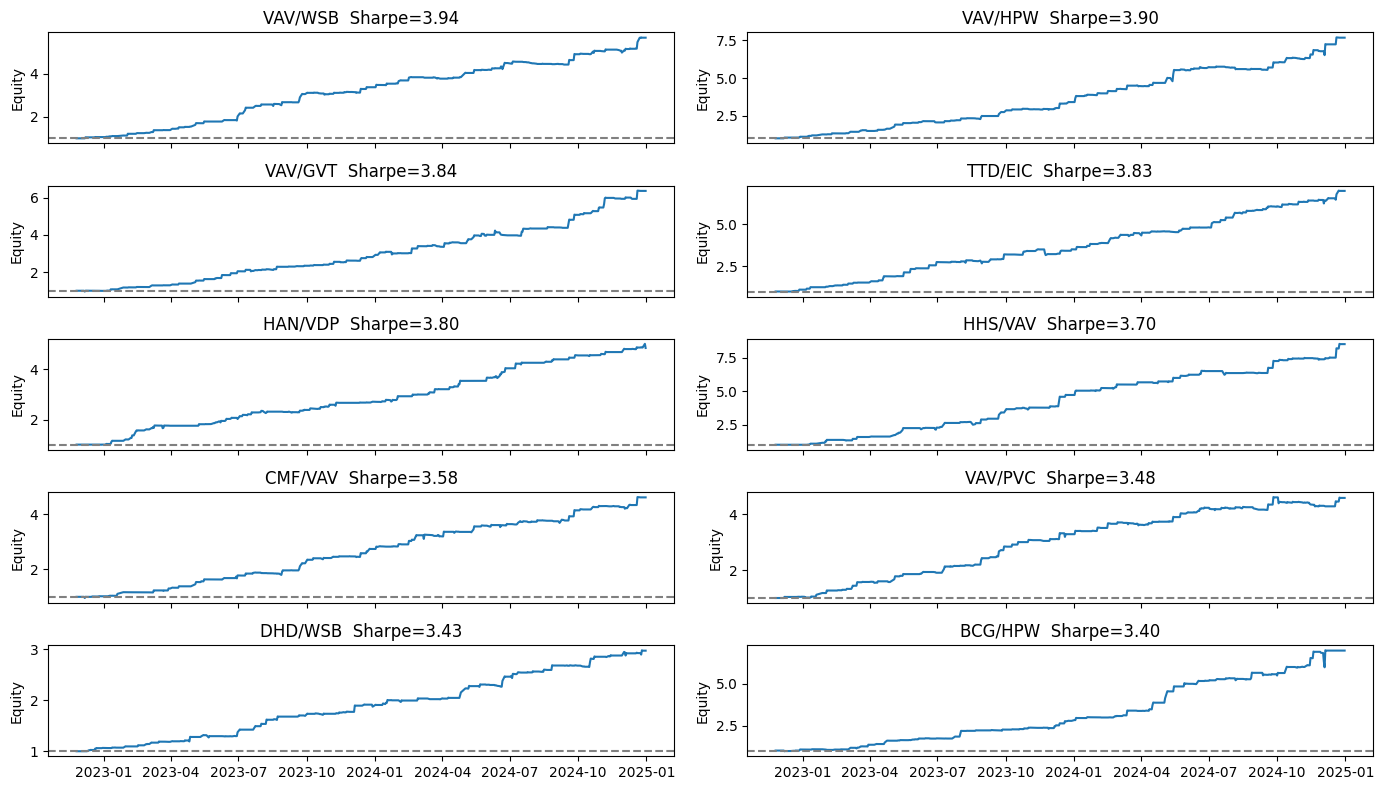

In [107]:
# 10) Plot top-10 equity curves
fig, axes = plt.subplots(5, 2, figsize=(14,8), sharex=True)
for ax, pair in zip(axes.flatten(), top10):
    eq = cumrets[pair]
    ax.plot(eq, lw=1.5)
    ax.set_title(f"{pair}  Sharpe={metrics_df.at[pair,'sharpe']:.2f}")
    ax.axhline(1, color="gray", ls="--")
    ax.set_ylabel("Equity")
plt.tight_layout()
plt.show()

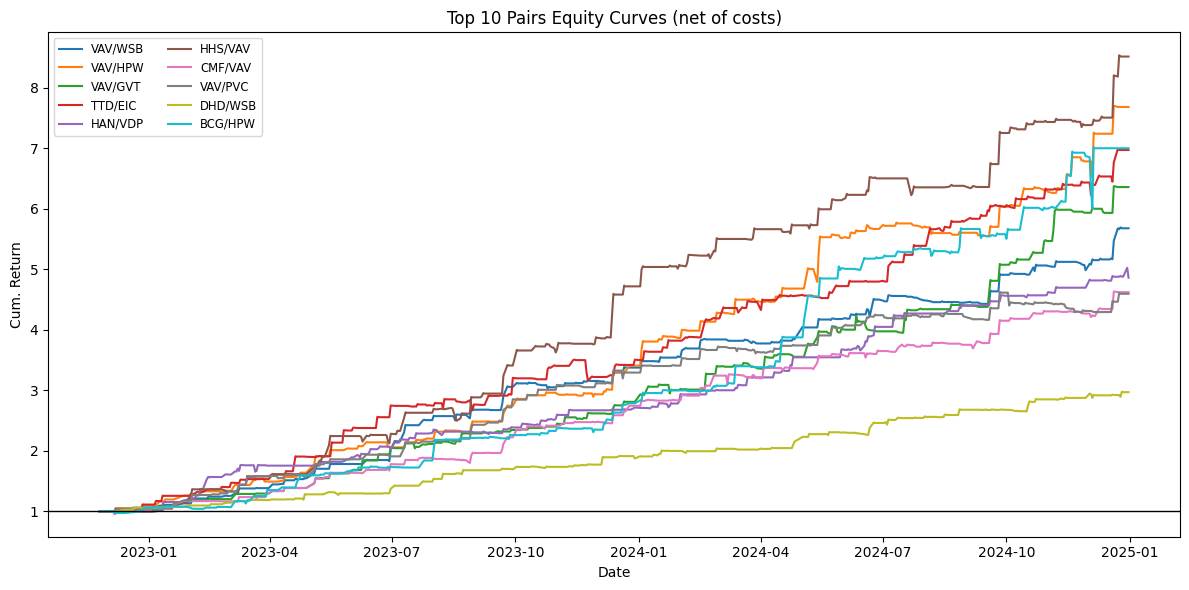

In [108]:
# 11) Overlay all top-10
plt.figure(figsize=(12,6))
for pair in top10:
    plt.plot(cumrets[pair], label=pair)
plt.legend(ncol=2, fontsize="small")
plt.axhline(1, color="k", lw=1)
plt.title("Top 10 Pairs Equity Curves (net of costs)")
plt.ylabel("Cum. Return"); plt.xlabel("Date")
plt.tight_layout()
plt.show()

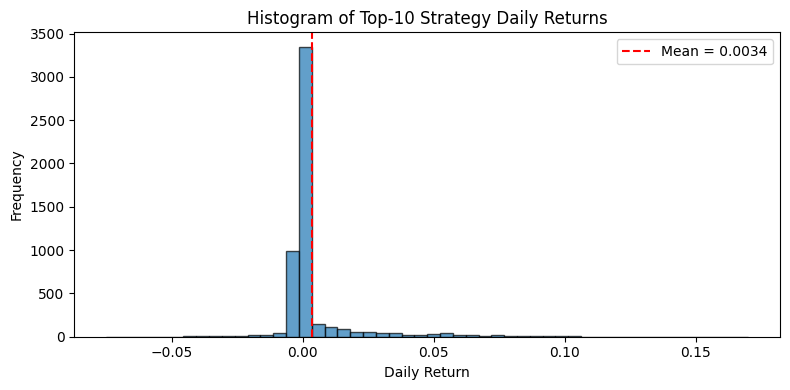

<Figure size 600x600 with 0 Axes>

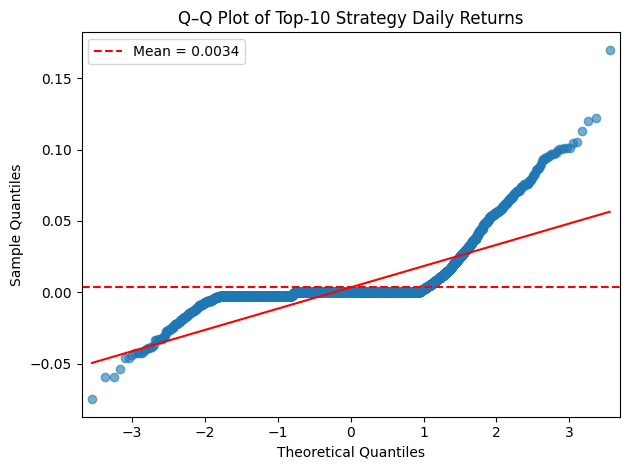

In [110]:
# ─── 8) RETURN DISTRIBUTION & Q–Q PLOT ─────────────────────────────────────
import statsmodels.api as sm

# 8.1) Collect all daily net returns from the top-10 equity series
all_rets = []
for pair in top10:
    # get net‐of‐costs series and compute daily returns
    eq = cumrets[pair]
    daily_ret = eq.pct_change().fillna(0)
    all_rets.append(daily_ret)

all_rets = pd.concat(all_rets)

# 8.2) Histogram of daily returns with mean line
mean_ret = all_rets.mean()

plt.figure(figsize=(8, 4))
plt.hist(all_rets, bins=50, edgecolor='k', alpha=0.7)
plt.axvline(mean_ret, color='r', linestyle='--',
            label=f'Mean = {mean_ret:.4f}')
plt.title('Histogram of Top-10 Strategy Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# 8.3) Normal Q–Q plot with mean line
plt.figure(figsize=(6, 6))
qq = sm.qqplot(all_rets, line='s', alpha=0.6)
plt.title('Q–Q Plot of Top-10 Strategy Daily Returns')

# add horizontal mean line
plt.axhline(mean_ret, color='r', linestyle='--', label=f'Mean = {mean_ret:.4f}')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

2025-05-22 00:15:32 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.
2025-05-22 00:15:33 - vnstock.common.data.data_explorer - INFO - Không phải là mã chứng khoán, thông tin công ty và tài chính không khả dụng.



Benchmark VNINDEX:
  CAGR:         18.00%
  Sharpe Ratio: 0.78
  Ann. Vol:     16.38%
  Max Drawdown: 17.80%

Benchmark VN30:
  CAGR:         22.92%
  Sharpe Ratio: 0.89
  Ann. Vol:     17.82%
  Max Drawdown: 17.85%


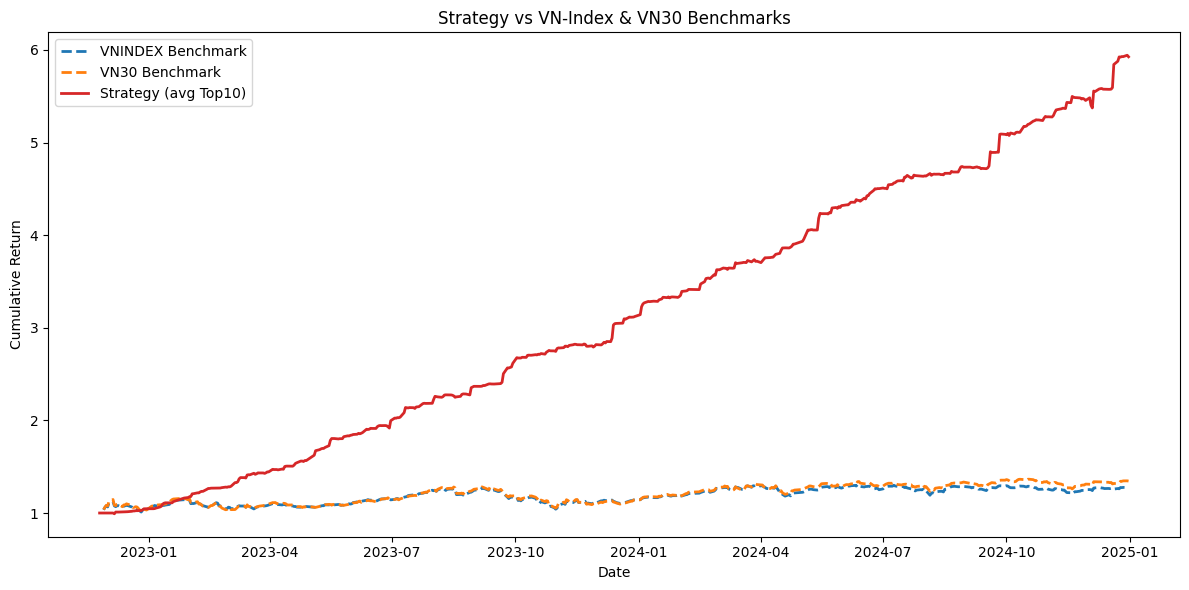

In [111]:
# ─── 9) BENCHMARK COMPARISON WITH VN-INDEX & VN30 ─────────────────────────────
from vnstock import Vnstock
from math import sqrt

vn = Vnstock()

# Derive test window from your strategy index:
# (pick any cumrets series; they all share the same index)
any_eq = next(iter(cumrets.values()))
start_ts = any_eq.index[0]
end_ts   = any_eq.index[-1]

def fetch_index(symbol, start, end, source=None):
    idx = vn.stock(symbol=symbol, source=source)
    hist = idx.quote.history(
        start=start.strftime("%Y-%m-%d"),
        end=end.strftime("%Y-%m-%d"),
        interval="1D"
    )
    series = hist.set_index("time")["close"]
    # align to your backtest dates & forward-fill
    series = series.reindex(any_eq.index).ffill()
    # log returns → equity
    rets   = np.log(series).diff().dropna()
    cum    = (1 + rets).cumprod()
    ann_vol = rets.std() * sqrt(252)
    ann_ret = rets.mean() * 252
    sharpe  = ann_ret / ann_vol if ann_vol>0 else np.nan
    max_dd  = ((cum.cummax() - cum) / cum.cummax()).max()
    cagr    = cum.iloc[-1] ** (365.25/len(cum)) - 1
    return {
        "cum": cum,
        "vol": ann_vol,
        "ret": ann_ret,
        "sharpe": sharpe,
        "max_dd": max_dd,
        "cagr": cagr,
    }

# Fetch VNINDEX and VN30 from best available source
benchmarks = {}
for sym in ["VNINDEX", "VN30"]:
    for src in ["VCI", "SSI", "TCBS"]:
        try:
            benchmarks[sym] = fetch_index(sym, start_ts, end_ts, source=src)
            break
        except Exception:
            continue

# Print benchmark stats
for sym, stats in benchmarks.items():
    print(f"\nBenchmark {sym}:")
    print(f"  CAGR:         {stats['cagr']:.2%}")
    print(f"  Sharpe Ratio: {stats['sharpe']:.2f}")
    print(f"  Ann. Vol:     {stats['vol']:.2%}")
    print(f"  Max Drawdown: {stats['max_dd']:.2%}")

# Strategy average of top-10 equity
strat_avg = pd.concat([cumrets[p] for p in top10], axis=1).mean(axis=1)

# Plot all together
plt.figure(figsize=(12,6))
for sym, st in benchmarks.items():
    plt.plot(st["cum"], "--", lw=2, label=f"{sym} Benchmark")
plt.plot(strat_avg, "-", lw=2, color="tab:red", label="Strategy (avg Top10)")

plt.title("Strategy vs VN-Index & VN30 Benchmarks")
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.legend(); plt.tight_layout(); plt.show()


In [112]:
# ─── 12) TOTAL RETURNS PERFORMANCE SUMMARY ──────────────────────────────────
# Strategy metrics (on the average Top-10 equity curve)
strategy_eq       = strat_avg
rets_strat        = strategy_eq.pct_change().dropna()
strategy_total    = strategy_eq.iloc[-1] - 1
strategy_ann_ret  = rets_strat.mean() * 252
strategy_ann_vol  = rets_strat.std()  * np.sqrt(252)
strategy_sharpe   = strategy_ann_ret / strategy_ann_vol if strategy_ann_vol>0 else np.nan
strategy_dd       = (strategy_eq.cummax() - strategy_eq).max()
strategy_cagr     = strategy_eq.iloc[-1] ** (365.25 / len(strategy_eq)) - 1

print("\nTotal Returns Performance Summary")
print("──────────────────────────────────────────")
print(f"Strategy (Avg Top-10):")
print(f"  Total Return:      {strategy_total:.2%}")
print(f"  CAGR:              {strategy_cagr:.2%}")
print(f"  Ann. Volatility:   {strategy_ann_vol:.2%}")
print(f"  Sharpe Ratio:      {strategy_sharpe:.2f}")
print(f"  Max Drawdown:      {strategy_dd:.2%}\n")

# Print each benchmark’s performance
for sym, stats in benchmarks.items():
    bench_eq    = stats["cum"]
    bench_total = bench_eq.iloc[-1] - 1
    print(f"Benchmark {sym}:")
    print(f"  Total Return:      {bench_total:.2%}")
    print(f"  CAGR:              {stats['cagr']:.2%}")
    print(f"  Ann. Volatility:   {stats['vol']:.2%}")
    print(f"  Sharpe Ratio:      {stats['sharpe']:.2f}")
    print(f"  Max Drawdown:      {stats['max_dd']:.2%}\n")



Total Returns Performance Summary
──────────────────────────────────────────
Strategy (Avg Top-10):
  Total Return:      492.54%
  CAGR:              244.82%
  Ann. Volatility:   12.23%
  Sharpe Ratio:      7.07
  Max Drawdown:      12.41%

Benchmark VNINDEX:
  Total Return:      26.80%
  CAGR:              18.00%
  Ann. Volatility:   16.38%
  Sharpe Ratio:      0.78
  Max Drawdown:      17.80%

Benchmark VN30:
  Total Return:      34.46%
  CAGR:              22.92%
  Ann. Volatility:   17.82%
  Sharpe Ratio:      0.89
  Max Drawdown:      17.85%



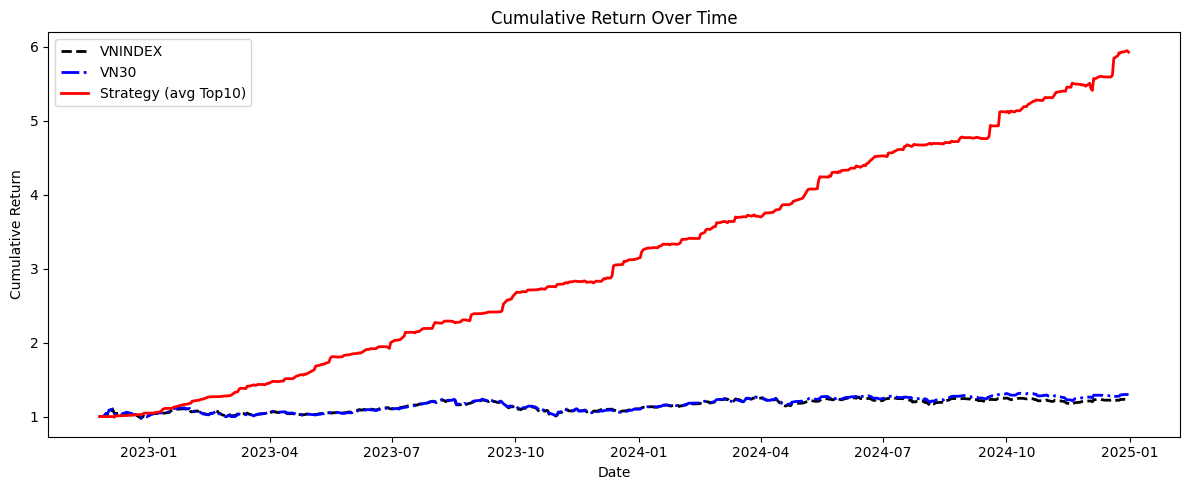

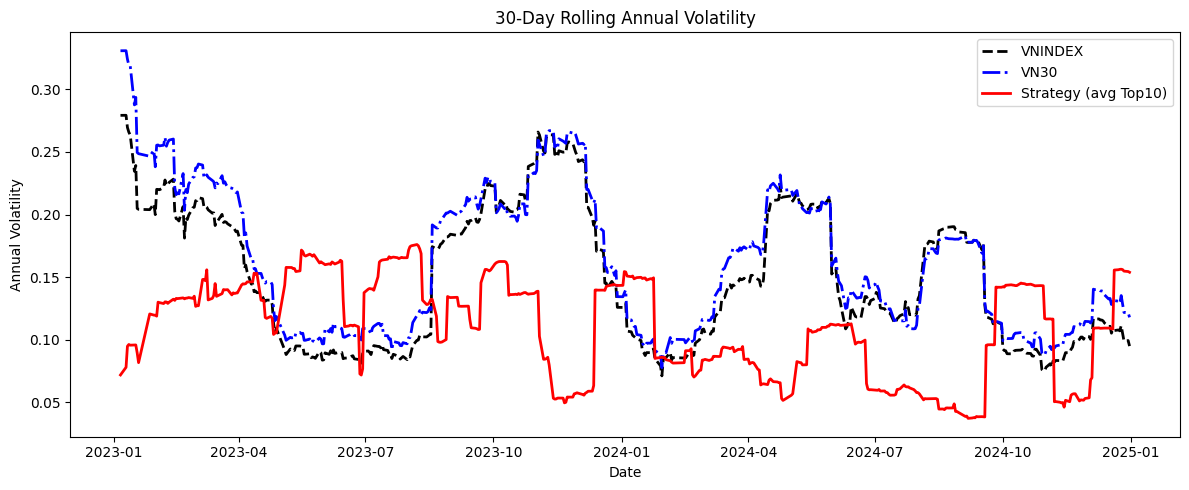

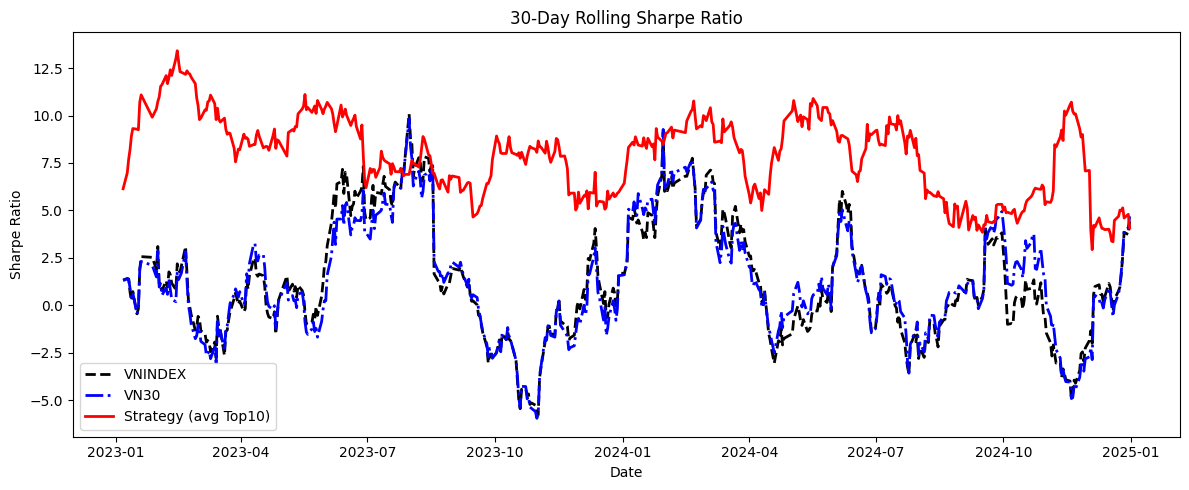

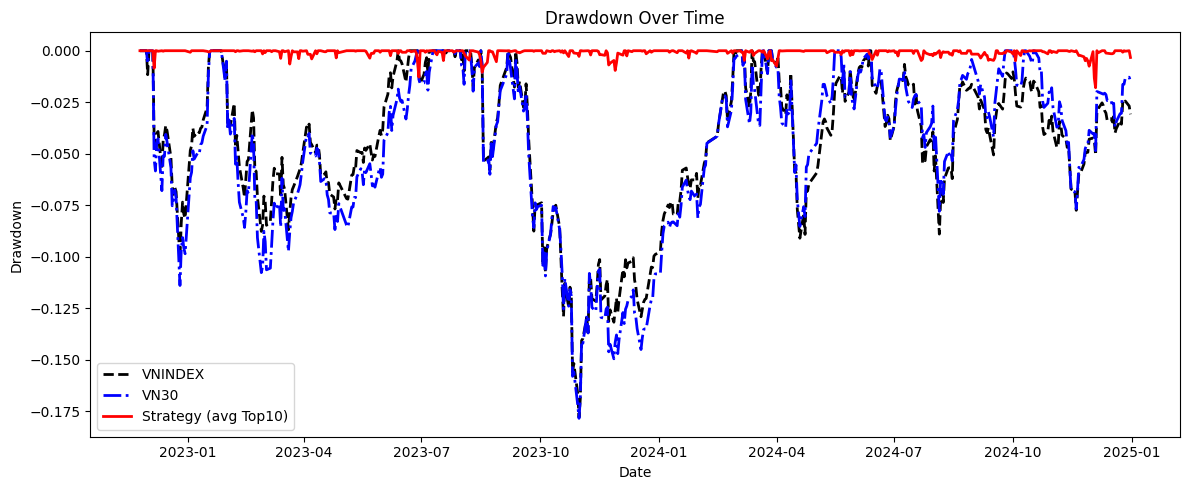

In [113]:
# ─── 10) ROLLING METRIC TIME-SERIES PLOTS FOR VN BENCHMARKS ────────────────────
WINDOW = 30  # rolling window in days

# 10.0) Strategy & benchmark daily returns
strat_ret   = pd.concat(
    [cumrets[pair].pct_change().fillna(0) for pair in top10],
    axis=1
).mean(axis=1)

def get_index_rets(sym):
    series = benchmarks[sym]["cum"]
    rets   = series.pct_change().fillna(0)
    return rets.reindex(strat_ret.index).fillna(0)

vnidx_ret  = get_index_rets("VNINDEX")
vn30_ret   = get_index_rets("VN30")

# 10.1) Cumulative returns
cum_strat = (1 + strat_ret).cumprod()
cum_vnidx = (1 + vnidx_ret).cumprod()
cum_vn30  = (1 + vn30_ret).cumprod()

# 10.2) Rolling annualized volatility
vol_strat = strat_ret.rolling(WINDOW).std() * np.sqrt(252)
vol_vnidx = vnidx_ret.rolling(WINDOW).std() * np.sqrt(252)
vol_vn30  = vn30_ret.rolling(WINDOW).std() * np.sqrt(252)

# 10.3) Rolling Sharpe ratio
sr_strat = (
    strat_ret.rolling(WINDOW).mean() /
    strat_ret.rolling(WINDOW).std()
) * np.sqrt(252)

sr_vnidx = (
    vnidx_ret.rolling(WINDOW).mean() /
    vnidx_ret.rolling(WINDOW).std()
) * np.sqrt(252)

sr_vn30 = (
    vn30_ret.rolling(WINDOW).mean() /
    vn30_ret.rolling(WINDOW).std()
) * np.sqrt(252)

# 10.4) Drawdown series
dd_strat = cum_strat / cum_strat.cummax() - 1
dd_vnidx = cum_vnidx / cum_vnidx.cummax() - 1
dd_vn30  = cum_vn30  / cum_vn30.cummax()  - 1

# Plot helper
def ts_plot(s_strat, s_vnidx, s_vn30, title, ylabel):
    plt.figure(figsize=(12, 5))
    plt.plot(s_vnidx, "k--", lw=2, label="VNINDEX")
    plt.plot(s_vn30,  "b-.", lw=2, label="VN30")
    plt.plot(s_strat,"r-",  lw=2, label="Strategy (avg Top10)")
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(ylabel)
    plt.legend()
    plt.tight_layout()
    plt.show()

# 10.1) Plot Cumulative Return
ts_plot(cum_strat, cum_vnidx, cum_vn30,
        "Cumulative Return Over Time", "Cumulative Return")

# 10.2) Plot Rolling 30-Day Annualized Volatility
ts_plot(vol_strat, vol_vnidx, vol_vn30,
        f"{WINDOW}-Day Rolling Annual Volatility", "Annual Volatility")

# 10.3) Plot Rolling 30-Day Sharpe Ratio
ts_plot(sr_strat, sr_vnidx, sr_vn30,
        f"{WINDOW}-Day Rolling Sharpe Ratio", "Sharpe Ratio")

# 10.4) Plot Drawdown Over Time
ts_plot(dd_strat, dd_vnidx, dd_vn30,
        "Drawdown Over Time", "Drawdown")
